## 개요 

참여중인 딥러닝 스터디 4주차 기록입니다.

## 3주차 과제 설명(MNIST 설명)

* Binary(Hypothesis : Sigmoid, CrossEntropy : Y, 1-Y) <br>
  → Multiclass(Hypothesis : Softmax, CrossEntropy : $Y_1$, $Y_2$...)

* MNIST
  * 데이터사이언스, 딥러닝에서의 기초(코딩의 Hello world와 같음)
  * 사람들의 손글씨 데이터를 모아둔 유명한 데이터 셋
  ```python
    # tensorflow MNIST로딩 샘플코드
    from tensorflow.keras.datasets import mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    print(x_train.shape, y_train.shape, y_train[0])

    >>>(60000, 28, 28) (60000,) 5 
    # 6만건의 28*28형태의 데이터 (x_train.shape), 6만건의 0차원 형태 데이터(y_train.shape), 0번째 y_train 정답값(5)
  ```

## 3주차 과제 설명(MNIST의 Softmax구현)
* MNIST의 Softmax구현
  * reshape을 사용하는 이유
    * 모델에 통과시키기 위해 행렬을 flatten(28\*28 → 784\*1)한 후, 다시 Visualize할 때 사용
    ```python
      img = x_train[i].reshape(28,28)
      plt.imshow(img, cmap=plt.cm.binary)
    ```
  * Hyper parameter
    * Parameter : W와 b와 같은 학습을 통해 최적화하는 값
    * Hyper parameter : 모델의 선택(Linear vs Logistic regression), learning_rate, epoch, class(몇개로 나눌지), feature(input data) 등
    ```python
      # MNIST dataset parameters
      num_classes = 10
      num_features = 28 * 28 # 784

      # Training parameters
      learning_rate = 0.01
      steps = 1000
      batch_size = 256
    ```
  * np.array : list형태의 train data를 수학적 연산에 유리한 numpy로 변환하기 위해 사용
    * 권장하는 코딩습관 : 아래와 같이 데이터타입을 명시 (안적어도 float32로 기본지정되긴 함)
      * np.array(x_train) → np.array(x_train, np.float32)
    ```python
      x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
    ```
  
  * 구조변경(flatten)
    * reshape([-1, num_features]) : flatten 구현
      * 784 data에 reshape([-1, 28]) : reshape의 -1 부분은 28이 됨
      * 784 data에 reshape([-1, 784]) : reshape의 -1 부분은 1이 됨
    ```python
      # data 구조를 통일
      x_train = x_train.reshape([-1, num_features])
      x_test = x_test.reshape([-1, num_features])
      print(x_train.shape, x_test.shape)
      >>> (60000, 784) (10000, 784)
    ```
  
  * 데이터 전처리(Normalize, Zero-centering)
    ```python
      x_train, x_test  = x_train / 255. , x_test / 255. # Normalizd
      x_train, x_test = (x_train-np.mean(x_train)), (x_test-np.mean(x_test)) # Zero-Centering
    ```
  
  * Variable 설정
    * W와 b의 Shape은 결정해주어야 함 (W의 차원파악 중요)
      * W : input dimesion, output dimesion
      * b : number of classes(output dimesion)
      ```python
        W = tf.Variable(tf.ones([num_features, num_classes]), name = 'weight')
        b = tf.Variable(tf.zeros([num_classes]), name='bias')
      ```
  
  * Hypothesis와 평가방법(accuracy) 등 설정
    ```python
      def softmax(x):
        z = tf.matmul(x, W) + b
        sm = tf.nn.softmax(z)
        return sm

      def cross_entropy(y_pred, y_true):
        y_true = tf.one_hot(y_true, depth=num_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
        return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis = 1))

      def accuracy(y_pred, y_true):
        correct_prediction = tf.equal(tf.argmax(y_pred, axis=1), tf.cast(y_true, tf.int64))
        return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    ```
  * Optimizer
    ```python
      optimizer = tf.optimizers.SGD(learning_rate)
      def run_optimization(x,y):
        with tf.GradientTape() as tape:
          pred = softmax(x)
          loss = cross_entropy(pred, y)

        gradients = tape.gradient(loss, [W,b])

        optimizer.apply_gradients(zip(gradients, [W,b]))
    ```

  * Batch size구현
    * 아래 코드는 기초적 구현이며, 중복제거나 차례대로 진행되는 기능 등도 있음
      * 왜? 데이터가 시점 등에 따라 패턴이 있을 수 있다
        * 100개의 데이터를 10등분했을 때, 각 데이터마다 패턴이 있을 수 있음
        * 편향되지 않게 섞는 것이 batch_size의 기본적 컨셉
    ```python
      n_train = x_train.shape[0] # 60000
      n_test = x_test.shape[0]   # 10000

      def train_batch_maker(batch_size):
        random_idx = np.random.randint(n_train, size = batch_size) # (batch_size,) vector
        return x_train[random_idx], y_train[random_idx]            # (batch_size, 28*28)

      def test_batch_maker(batch_size):
        random_idx = np.random.randint(n_test, size = batch_size)   # (batch_size,) vector
        return x_test[random_idx], y_test[random_idx]               # (batch_size, 28*28)
    ```
  
  * 학습 및 Test
  ```python
    for step in range(steps):
    batch_x, batch_y = train_batch_maker(batch_size)

    # Run the optimization to update W and b values
    run_optimization(batch_x, batch_y)

    if step % 100 == 0:
      pred = softmax(batch_x)
      loss = cross_entropy(pred, batch_y)
      acc = accuracy(pred, batch_y)
      print(f"step: {step} loss: {loss} accuracy: {acc}")

    pred = softmax(x_test)
    print(f"Test Accuracy: {accuracy(pred, y_test)}")
    >>> Test Accuracy: 0.8712000250816345

    #Predict 5 images from validaton set.
    num_images = 5
    test_images = x_test[:num_images]
    predictions = softmax(test_images)

    # Visualize image and model predcition
    plt.figure(figsize = (5,5))
    for i in range(num_images):
      plt.subplot(1, num_images, i+1)
      plt.imshow(np.reshape(test_images[i], [28,28]), cmap=plt.cm.binary)
      plt.xlabel(np.argmax(predictions.numpy()[i]))

    plt.show()
  ```
    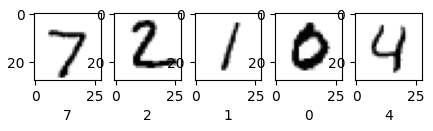

## 4주차 정리

### Deep Neural Network (Convolution NN)

* 딥러닝은 비선형적 관계를 잘 묘사함
  * 과거에는 숫자데이터(금리, 고용률 등)만 다룰 수 있었음
  * 이미지 등 비정형데이터를 잘 다룰 수 있게됨

* CNN(Convolutional Neural Network)
  * 이미지를 분류, 처리하는 기술
    * 분류(Classification) : 대상이 어디에 속하는지 분류
    * 식별(Detection) : 사진에서의 어떤 객체를 분류하고, 그 객체가 어디에 속하는지 분류
    * 이러한 분류와 식별을 응용하여 자율주행 자동차, 얼굴인식App 등 구현 가능 (CNN Architecture영향을 받아 발전)\
  * CNN의 구성
    * 특성추출(feature learning)
      * 사진은 많은 정보를 포함해 계산량이 너무 많아지므로, 특성추출을 통해 압축이 필요함
      * CNN은 모델이 이런 정보에서 어느 부분이 중요한지 찾게 만듦
      * **특성추출로 압축된 정보를 Neural Network에 넣어, 원본사진 넣은 것과 동일한 것처럼, 빠르고 가볍게 돌아감**<br>
        (예를 들어 자율주행에 활용하기 위해서는 짧은 시간에 처리해야함)
      * Convolution alyer(정보압축) / Pooling layer(정보버림) 등의 반복
    * Classification
      * Flatten / Fully-connected / Softmax 등 3주차까지 배운 내용
  * Convolution layer
    * Source(X)에 Kernel(W)행렬을 곱해 Result(Y)를 만드는것과 같음
      * 원본이미지(Source)의 손실을 최소화하며 잘 압축하는 좋은Kernel값을 찾고자 함
      * 아다마르곱 활용 : 매칭되는 칸의 숫자끼리 곱하여 더함<br>
        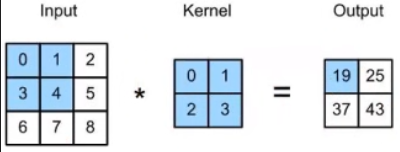
    * Convolution layer를 통과해 (28,28)이 (14,14)가 되어도 특징 식별 가능
      * CNN은, 마스크 쓴 사람의 일부 얼굴 특징만으로 사람을 판단하는 것과 같은 방법을 차용
    * CNN이 잘 작동하기 위한 가정
      * Spatial Locality : 사진의 일부만 봐도 식별이 가능하다
      * Positional invariance : 이미지에서 사과 등 객체가 어디에 있던 사과임
        * 예외 상황 : 엑스레이의 흰색이 위치에 따라 심장, 간 등 다름
  * Convolution layer 추가설명
    * image(32,32,3)를 filter(3,3,3)가 움직이며 아다마르곱으로 처리
      * kernel과 filter는 동일한 의미로 사용
        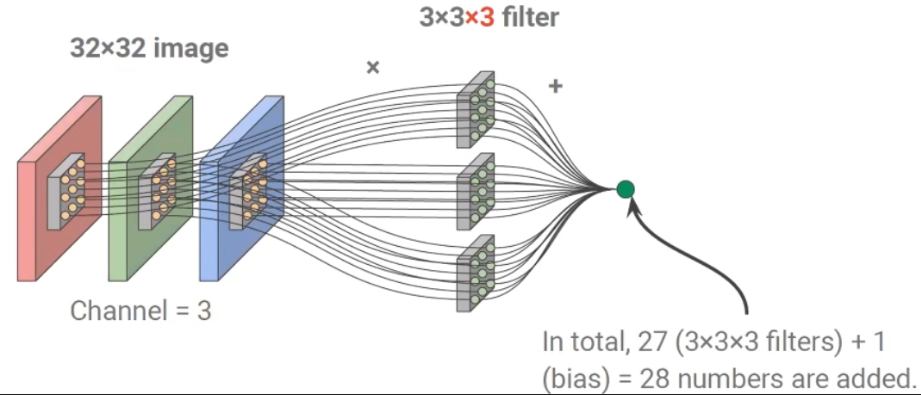
      * (32X32X3)image에 (5X5X3)filter 적용시 output은 (28X28X1)
        * output은 activation map임(매핑을 했다는 것)
      * (32X32X3)image에 (5X5X3)filter 4개를 적용하는 이유?
        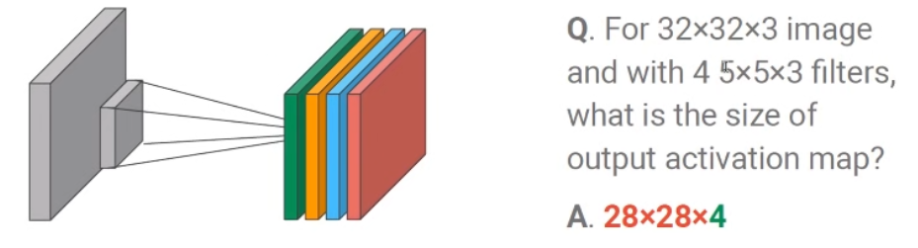
        * 필터가 필요했던 이유는 정보 압축 → 정보가 작아지며 손실 발생
          (코끼리의 일부만을 보는 것과 같음)
        * 각 부분의 정보(4개의 filter)를 모두 모아서 정확히 알 수 있음
          (4개의 filter라는 서로 다른 각도에서 본 코끼리를 합쳐서 보게되는 것)

  * Nested Conv-layers(Convolution layer에 대한 문제)
    * Layer를 여러번 통과하여 너무 작아지는 문제(get smaller quickly) + 4k와 같은 큰 데이터의 계산량 문제
    * 이러한 문제를 방지하기 위해 stride와 padding이라는 parameter를 추가

  * Stride
    * (Input - Filter) / stride + 1
      * (7x7)image에 (3X3)filter, stride 1 → (7-3)/1 + 1 = (5X5)
      * (7x7)image에 (3X3)filter, stride 2 → (7-3)/2 + 1 = (3X3)
      * (7x7)image에 (3X3)filter, stride 3 → (7-3)/3 + 1 = (2.33X2.33) 
        * output 소수인 것은 불가, padding(가장 자리에 0을 붙여줌)을 사용
    * **(Input - Filter + 2 $*$ Padding) / stride + 1**
      * Padding을 2배하는 이유는 양쪽 테두리에 각 1개씩 추가되기 때문
  
  * 예시
    * Input (32x32x3) / 10 Filter(5X5) / stride 1, pad 2
      * Output size(=32X32X10) : (32-5+2*2)/1 + 1 → (32X32) → 10개의 필터
      * Number of Parameter(=760) : (Filter (5X5) * Input의 차원 3 + Bias 1) → (5*5*3+1) → 필터 10개 → (5*5*3+1) * 10
      * Number of Parameter if fully-connected(=31,467,520) : (32*32*10)*(32*32*3_1)
        * Fully-connected로 31,467,520개 파라미터가 필요했다면, CNN으로 760개 파라미터로 가능해짐

  * 관례적으로 filter size는 정사각형이지만 직사각형도 가능하다

  * Pooling Layer : 쓸모없는 정보를 버림
    * Pooling Layer의 종류
      * Max pooling : 제일 큰 수만 가져옴
      * Average pooling : 평균 가져옴
      * Parameters 0개 (숫자를 찾는게 아닌 버림. 학습이 일어나지 않음)
    * Pooling Layer의 특징
      * 파라미터수가 0 (학습이 일어나지 않는다, Kernel[Filter]처럼 좋은 숫자를 찾는 작업이 없기 때문)

### Final project 설명

* 28만건의 신용카드 데이터로 만들기

* 금융데이터는 privacy이슈가 있어 공개시 익명화되어있음
  * 단위가 다르면 연봉, 자산 여부를 역추적할 수 있어, PCA를 통해 익명화 가능
    * PCA : 데이터 익명화기법은 아니고 처리기법
    * V1, V2와 같은 세상에 존재하지 않는 축으로 변환하기때문에 익명화에 좋다
    * 원래는 상관관계를 0이 되게만드는 테크닉

* Missing value 처리
  * 평균,최빈,중앙 값 중 프로젝트에 가장 적합한 값 사용하여 대치

* 상관관계 파악 (Heatmap 분석)
  * 과제의 금융데이터는 PCA로 인해 상관관계가 이미 사라져있음

* 데이터의 구조 파악
  * class : 0정상 1이상거래 (0.17%만이 이상거래 → 모델평가시 고려)

* 불필요한 컬럼 삭제

* Target이 합쳐져있는 원본데이터이므로 X, Y로 나누는 작업 필요

* 모델 평가
  * 99프로가 정상거래인데 99프로 정상임을 맞췄다면, 단순히 모델이 좋다고 보기 어려움
    * Precision, Recall, F1-Score → 이상거래를 몇건 맞췄는지 볼 수 있음

* 평가지표는 f1-score를 사용 예정
  * 바꾸고싶다면 사유 명시(어떤 부분을 중요하게 생각하여 Recall을 기준으로 삼았다)